# Static Ordinal Regression with MIMIC dataset using TensorFlow
---------

## Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
sys.path.append(os.path.abspath(os.path.join('../utils')))
from ordinal_model.ordinal_regression_TF import OrdinalLoss

## Data Preprocessing

In [4]:
X_train = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/x_train.csv')
y_train = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/y_train.csv')
X_valid = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/x_valid.csv')
y_valid = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/y_valid.csv')
X_test = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/x_test.csv')
y_test = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/y_test.csv')

In [5]:
X_data = [X_train, X_valid, X_test]
y_data = [y_train, y_valid, y_test]

In [6]:
X_train.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,hours_from_admission,timestamp,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure systolic,...,AST,Direct Bilirubin,Total Bilirubin,Troponin-T,Venous CO2 Pressure,admission_timestamp_x,Age,is_gender_male,is_gender_unknown,admission_timestamp_y
0,0,12466550,23998182,30000153,0.0,2174-09-29 12:09:00,104.0,16.0,100.0,113.0,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
1,1,12466550,23998182,30000153,1.0,2174-09-29 13:09:00,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
2,2,12466550,23998182,30000153,2.0,2174-09-29 14:09:00,83.0,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
3,3,12466550,23998182,30000153,3.0,2174-09-29 15:09:00,83.0,16.0,100.0,NaN,...,NaN,NaN,NaN,0.01,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
4,4,12466550,23998182,30000153,4.0,2174-09-29 16:09:00,103.0,20.0,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00


In [7]:
X_train.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id',
       'hours_from_admission', 'timestamp', 'Heart Rate', 'Respiratory Rate',
       'O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic', 'Temperature Fahrenheit',
       'Height (cm)', 'Respiratory Rate (Total)', 'Potassium (serum)',
       'Sodium (serum)', 'Chloride (serum)', 'Hematocrit (serum)',
       'Hemoglobin', 'Creatinine (serum)', 'Glucose (serum)', 'Magnesium',
       'Phosphorous', 'Platelet Count', 'Glucose (whole blood)',
       'Daily Weight', 'Absolute Neutrophil Count', 'Prothrombin time',
       'Fibrinogen', 'PH (Arterial)', 'PH (Venous)', 'HCO3 (serum)',
       'Arterial O2 pressure', 'Arterial CO2 Pressure', 'Lactic Acid',
       'Albumin', 'Calcium non-ionized', 'C Reactive Protein (CRP)', 'ALT',
       'AST', 'Direct Bilirubin', 'Total Bilirubin', 'Troponin-T',
       'Venous CO2 Pressure', 'admission_timestamp_x', 'Age', 'is_gender_male',


In [8]:
y_train.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,in_icu_mortality,length_of_stay_in_hours,admission_timestamp,los_geq_3_days,los_geq_7_days,los_geq_11_days
0,0,12466550,23998182,30000153,0,39.286111,2174-09-29 12:09:00,0,0,0
1,1,13180007,27543152,30000213,0,39.246667,2162-06-21 05:38:00,0,0,0
2,3,12207593,22795209,30000646,0,112.740556,2194-04-29 01:39:22,1,0,0
3,4,12168737,29283664,30001336,0,66.682222,2186-03-20 00:44:48,0,0,0
4,6,17461994,29537385,30001471,0,81.092500,2189-05-02 06:57:00,1,0,0


In [9]:
y_train.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'in_icu_mortality',
       'length_of_stay_in_hours', 'admission_timestamp', 'los_geq_3_days',
       'los_geq_7_days', 'los_geq_11_days'],
      dtype='object')

### Preprocess Functions
* `preprocess_X_df()`
    * Isolates the features of interest
    * Obtains the first observed values of certain features (i.e `Heart Rate`, `Non Invasive Blood Pressure diastolic`)
    * Optional: Normalize the data with the `normalize` flag set to `True`
* `preprocess_y_df()`
    * Isolates the labels for length of stays
    * Engineers ordinal feature labels

In [10]:
def preprocess_X_df(df, normalize=False):
    # Assume stay_id is primary key
    columns = ['stay_id', 'hours_from_admission', 'Heart Rate', 'Non Invasive Blood Pressure diastolic','Age', 'is_gender_male']
    # Sort the rows by admission time so that first value is earliest
    df = df[columns].copy().sort_values(['stay_id', 'hours_from_admission',])
    # Groupby
    preprocessed_df = df.groupby('stay_id').first()
    preprocessed_df = preprocessed_df.reset_index().drop(columns='hours_from_admission')
    # Fill na with mean values
    mean_values = preprocessed_df.mean()
    preprocessed_df = preprocessed_df.fillna(mean_values)
    # Normalize
    if normalize:
        normalize_cols = ['Heart Rate', 'Non Invasive Blood Pressure diastolic', 'Age']
        preprocessed_df[normalize_cols] = (preprocessed_df[normalize_cols] - preprocessed_df[normalize_cols].mean()) / preprocessed_df[normalize_cols].std()
    return preprocessed_df
    

In [11]:
def preprocess_y_df(df):
    # Assume stay_id is primary key, sort in same order as X dataset
    columns = ['stay_id', 'los_geq_3_days', 'los_geq_7_days', 'los_geq_11_days']
    df = df[columns].copy().sort_values(['stay_id'])
    # Determine ordinal label
    df['ordinal_label'] = df.iloc[:,-3:].sum(axis=1)
    return df

### Visualize feature distributions of first label

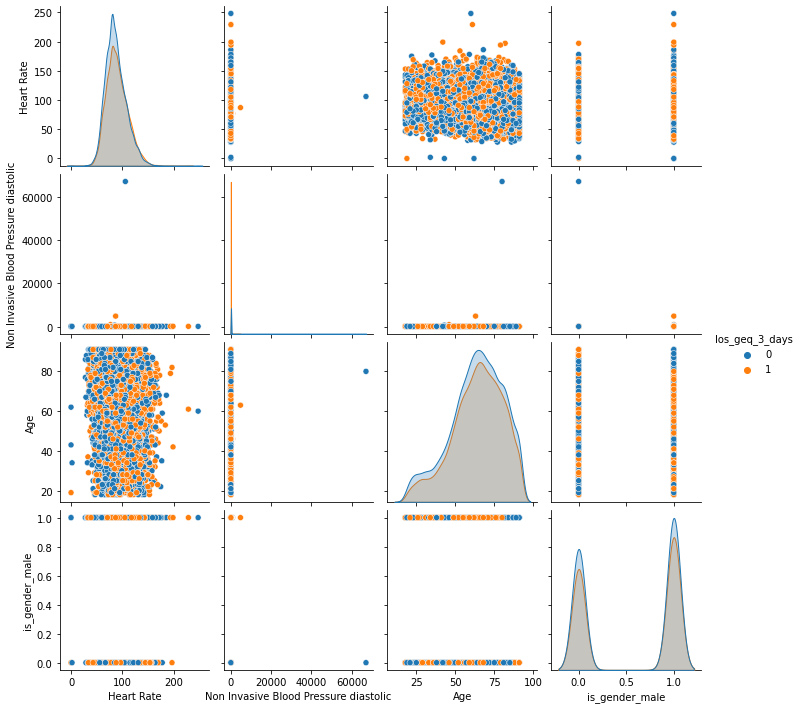

In [12]:
sns.pairplot(preprocess_X_df(X_train).merge(preprocess_y_df(y_train)[['stay_id', 'los_geq_3_days']], on='stay_id').iloc[:,1:], hue='los_geq_3_days')

# Binary Classification

## >3 days

In [13]:
# Use Keras Sequential to build a logistic regression model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='bce', metrics=['accuracy', 'bce'])
model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['los_geq_3_days'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['los_geq_3_days']),
    )

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1048/1048 [==============================] - 1s 1ms/step - loss: 0.7215 - accuracy: 0.5156 - bce: 0.7215 - val_loss: 0.8006 - val_accuracy: 0.5071 - val_bce: 0.8006
Epoch 2/10
1048/1048 [==============================] - 1s 1ms/step - loss: 0.6944 - accuracy: 0.5398 - bce: 0.6944 - val_loss: 0.7626 - val_accuracy: 0.5072 - val_bce: 0.7626
Epoch 3/10
1048/1048 [==============================] - 1s 1ms/step - loss: 0.6930 - accuracy: 0.5369 - bce: 0.6930 - val_loss: 0.7346 - val_accuracy: 0.510

In [14]:
# Predict probability scores for each dataset
y_score_train = model.predict(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = model.predict(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = model.predict(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

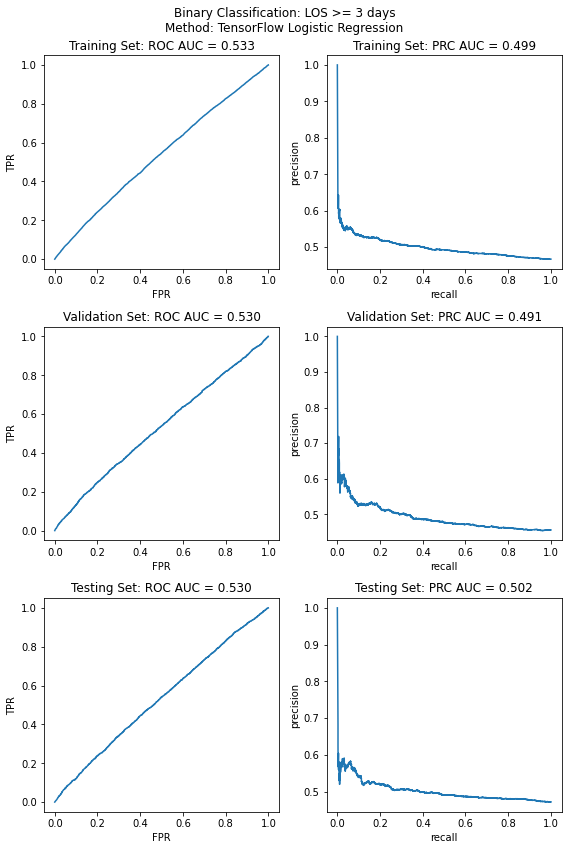

In [15]:
# Plot ROC & PRC
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 3 days\nMethod: TensorFlow Logistic Regression')
plt.tight_layout()
plt.show()

## >7 days

In [40]:
# Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='bce', metrics=['accuracy', 'bce'])
model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['los_geq_7_days'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['los_geq_7_days']),
    )

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1048/1048 [==============================] - 2s 2ms/step - loss: 0.6625 - accuracy: 0.6383 - bce: 0.6625 - val_loss: 0.5113 - val_accuracy: 0.8052 - val_bce: 0.5113
Epoch 2/10
1048/1048 [==============================] - 3s 3ms/step - loss: 0.4474 - accuracy: 0.8391 - bce: 0.4474 - val_loss: 0.4598 - val_accuracy: 0.8381 - val_bce: 0.4598
Epoch 3/10
1048/1048 [==============================] - 1s 1ms/step - loss: 0.4399 - accuracy: 0.8391 - bce: 0.4399 - val_loss: 0.4597 - val_accuracy: 0.838

In [41]:
# Predict prob scores for each dataset
y_score_train = model.predict(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = model.predict(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = model.predict(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

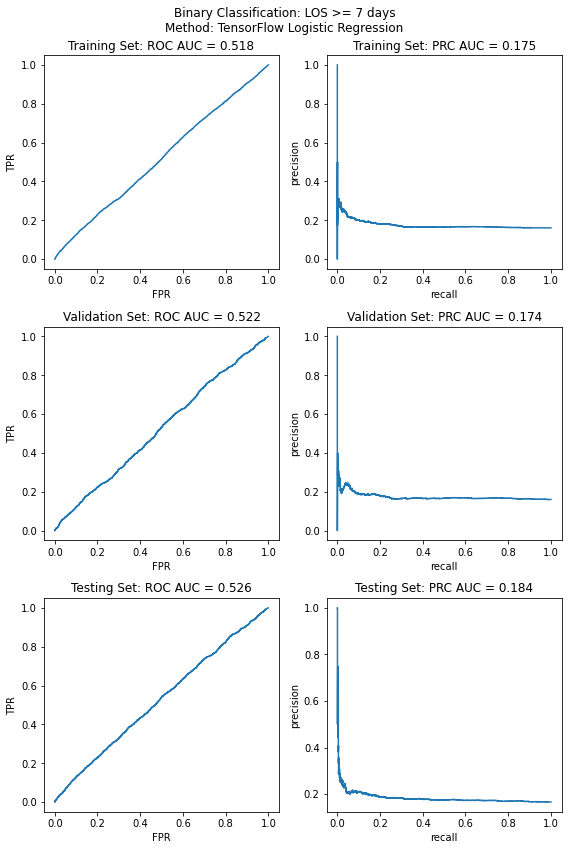

In [42]:
# Plot ROC & PRC
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 7 days\nMethod: TensorFlow Logistic Regression')
plt.tight_layout()
plt.show()

## >11 days

In [43]:
# Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='bce', metrics=['accuracy', 'bce'])
model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['los_geq_11_days'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['los_geq_11_days']),
    )

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1048/1048 [==============================] - 1s 1ms/step - loss: 0.4309 - accuracy: 0.8676 - bce: 0.4309 - val_loss: 0.3402 - val_accuracy: 0.9149 - val_bce: 0.3402
Epoch 2/10
1048/1048 [==============================] - 1s 1ms/step - loss: 0.3119 - accuracy: 0.9183 - bce: 0.3119 - val_loss: 0.3064 - val_accuracy: 0.9150 - val_bce: 0.3064
Epoch 3/10
1048/1048 [==============================] - 1s 1ms/step - loss: 0.2938 - accuracy: 0.9182 - bce: 0.2938 - val_loss: 0.2982 - val_accuracy: 0.915

In [44]:
# Predict probability scores for each dataset
y_score_train = model.predict(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = model.predict(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = model.predict(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

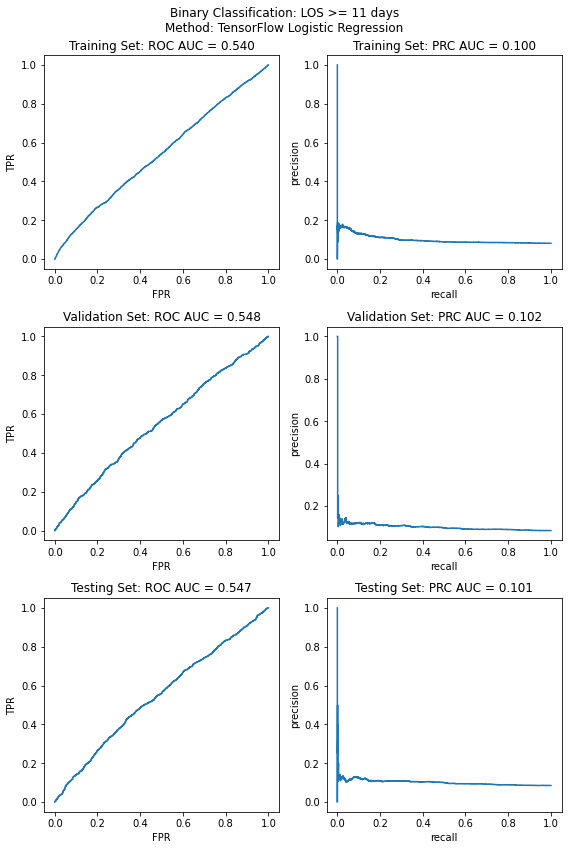

In [45]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 11 days\nMethod: TensorFlow Logistic Regression')
plt.tight_layout()
plt.show()

# Ordinal Classification

### Training and model summary

In [29]:
# Determine number of labels
R = preprocess_y_df(y_valid)['ordinal_label'].max() + 1

# Initialize cutpoints uniformly between 0-1 using number of labels
cutpoints = tf.Variable(
    initial_value=tf.range(R-1, dtype=np.float32) / (R-2),
    trainable=True,
    )

# Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.OrderedLogistic(cutpoints=cutpoints, loc=t))
])
model.compile(optimizer='adam', loss=OrdinalLoss())
history = model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['ordinal_label'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['ordinal_label']),
    )

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1048/1048 [==============================] - 2s 2ms/step - loss: 1.2393 - val_loss: 1.1257
Epoch 2/10
1048/1048 [==============================] - 1s 1ms/step - loss: 1.1053 - val_loss: 1.1186
Epoch 3/10
1048/1048 [==============================] - 1s 1ms/step - loss: 1.1011 - val_loss: 1.1174
Epoch 4/10
1048/1048 [==============================] - 1s 1ms/step - loss: 1.1008 - val_loss: 1.1161
Epoch 5/10
1048/1048 [==============================] - 1s 1ms/step - loss: 1.1007 - val_loss: 1.116

<function matplotlib.pyplot.show(close=None, block=None)>

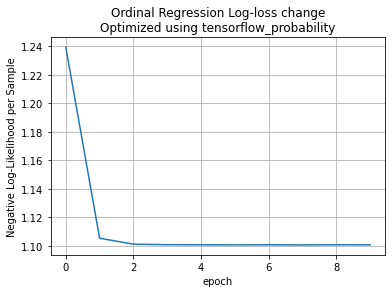

In [30]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [31]:
# Model Summary
tf.print(model.summary())
print(model.trainable_weights)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 5         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    3         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None
[<tf.Variable 'dense_4/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.15076025],
       [-0.4318094 ],
       [ 0.03622557],
       [ 0.07268293]], dtype=float32)>, <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float32, numpy=array([-0.7028615], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-0.52359474,  0.99923027,  1.7668167 ], dtype=float32)>]


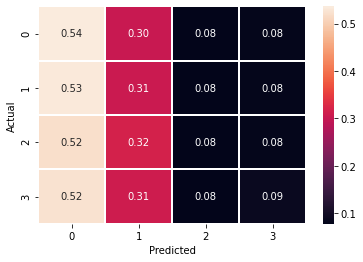

In [32]:
# Confusion Matrix
y = preprocess_y_df(y_train)['ordinal_label'].to_numpy()
y_predict = model.predict(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy())

cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [33]:
# Compute ordinal probabilities for each label
y_probas_train = model(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy()).categorical_probs().numpy().squeeze()
y_probas_valid = model(preprocess_X_df(X_valid, normalize=True).iloc[:,1:].to_numpy()).categorical_probs().numpy().squeeze()
y_probas_test = model(preprocess_X_df(X_test, normalize=True).iloc[:,1:].to_numpy()).categorical_probs().numpy().squeeze()


## >3 days

In [34]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq3 = y_probas_train[:,1:].sum(axis=1)
y_probas_valid_geq3 = y_probas_valid[:,1:].sum(axis=1)
y_probas_test_geq3 = y_probas_test[:,1:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

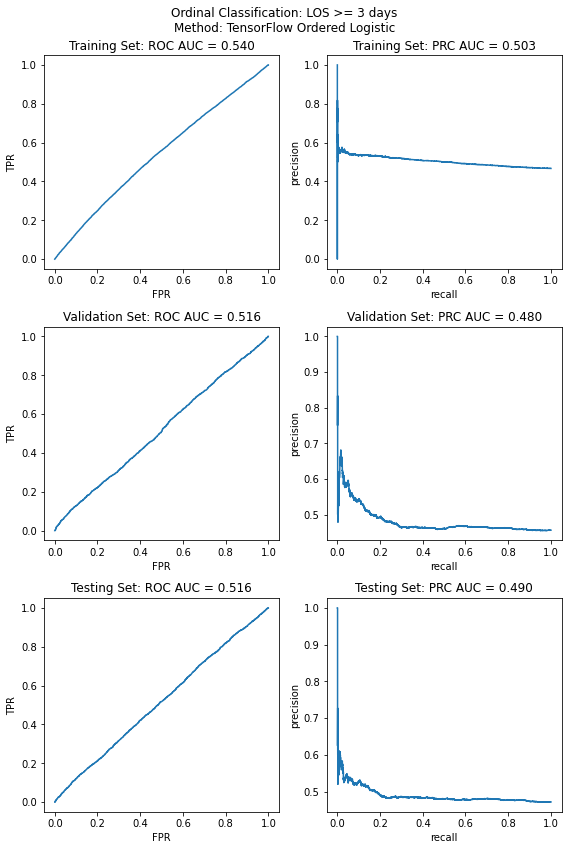

In [35]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 3 days\nMethod: TensorFlow Ordered Logistic')
plt.tight_layout()
plt.show()

## >7 days

In [36]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq7 = y_probas_train[:,2:].sum(axis=1)
y_probas_valid_geq7 = y_probas_valid[:,2:].sum(axis=1)
y_probas_test_geq7 = y_probas_test[:,2:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

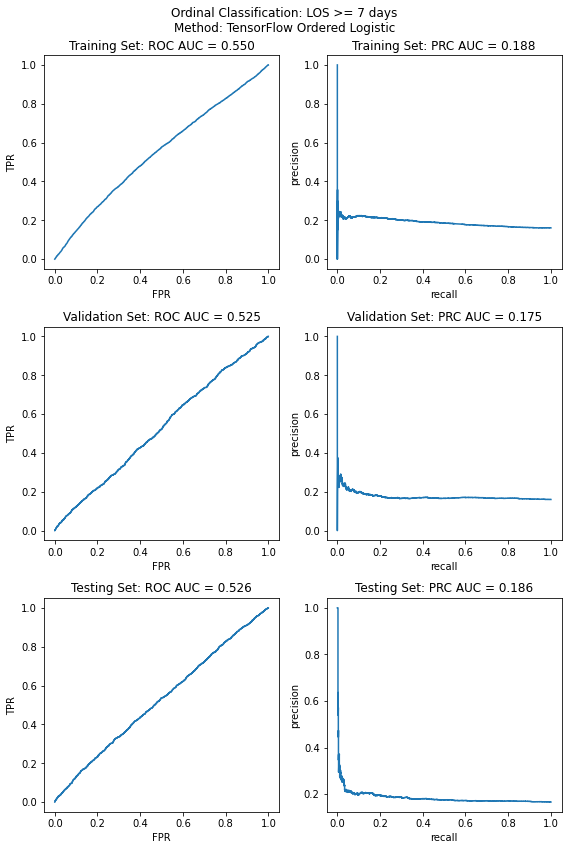

In [37]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 7 days\nMethod: TensorFlow Ordered Logistic')
plt.tight_layout()
plt.show()

## >11 days

In [38]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq11 = y_probas_train[:,3:].sum(axis=1)
y_probas_valid_geq11 = y_probas_valid[:,3:].sum(axis=1)
y_probas_test_geq11 = y_probas_test[:,3:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

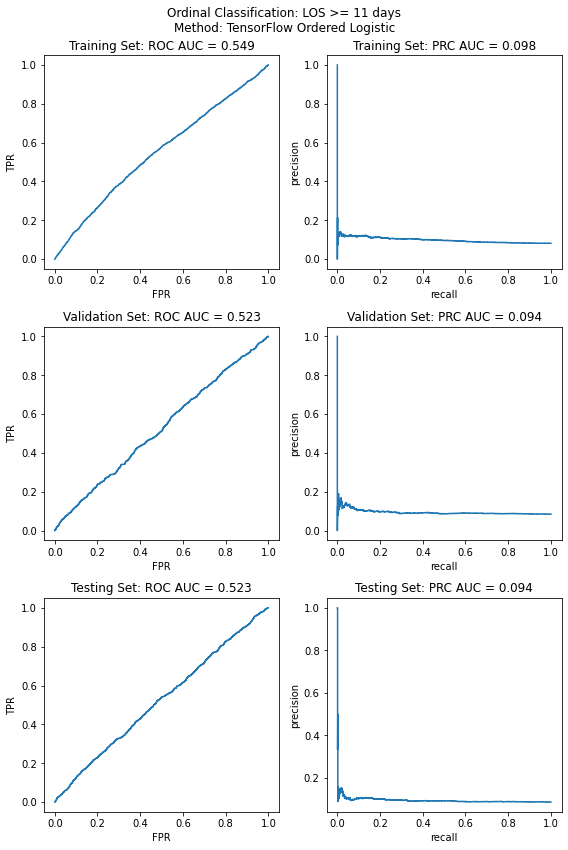

In [39]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 11 days\nMethod: TensorFlow Ordered Logistic')
plt.tight_layout()
plt.show()